# Evaluate_radiometrics_for_study_sites



The radiometric data is read in, and the palaevalley 2012 shapefile is used to create a mask to separate the region into known mapped palaeovalleys, and the surrounding region. The statistical difference between these two sites is then calculated using a t test and a Kolmogorov-Smirnov test. 

Created by Claire Krause
January 2017
Datacube version 1.1.17

### Dependancies in this code:
- csv file with the lat/lon coordinates of the case study bounding box/es
- palaeovalleys 2012 shape file

### Accompanying code

An accompanying notebook has been written that demonstrates the outputs from each step of this notebook. Refer to this accompanying notebook for further details of this notebook. 
- Evaluate_radiometrics_for_study_sites.ipynb

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import datacube
datacube.set_options(reproject_threads=1)
import numpy as np
from datacube.storage import masking
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas
import os 
import geopandas as gp
import csv

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

def pq_fuser(dest, src):
    valid_bit = 8
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

def write_to_csv(OUTPUT_path, row):
    if Studysite.Name == 'Blackwood2A':
        with open(OUTPUT_path,'w') as csvFile:
            writer = csv.writer(csvFile)
            header = ['name', 'ttest', 'KS_test']
            writer.writerow(header)
            writer.writerow(row)
    else:
        with open(OUTPUT_path,'a') as csvFile:
           writer = csv.writer(csvFile)
           writer.writerow(row)

## Import our list of case study sites and accompanying bounding boxes

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites_small.csv', delimiter = ',')
print(names)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

## Check for statistical difference between known palaeovalleys and outside region

#### NB. Note the reduced resolution from the datacube

This code uses 250 m x 250 m resolution, rather than the native 25 m x 25 m. This is done to make the code more effecient to run, and to minimise memory requirements on the VDI. The resolution can be changed back to 25 m, however the code will be very slow and would require paralellisation to run more quickly. 

In [4]:
dc = datacube.Datacube(app='radiometrics_analysis')

# Set up the paths to the input and output files
shp = gp.GeoDataFrame.from_file('/g/data/p25/cek156/Palaeovalleys_2012.shp')

for num, site in enumerate(names.Name[:-6]):
    Studysite = names.ix[num]
    print ('Working on ' + Studysite.Name)
    
    # Create a bounding box from the locations specified above
    box = shapely.geometry.box(names.minlon[num], names.minlat[num], names.maxlon[num], names.maxlat[num], ccw = True)
    # Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
    filtered = shp.where(shp.intersects(box)).dropna()
    # Combine all of the relevant polygons into a single polygon
    shp_union = shapely.ops.unary_union(filtered.geometry)

    # Read in the data from the datacube
    query = {'lat': (names.maxlat[num], names.minlat[num]), 
         'lon': (names.minlon[num], names.maxlon[num]),
         'resolution': (-250, 250), 'output_crs': 'EPSG:3577'}
    
    # Set up which dataset we want to loop through
    dataset = dc.index.products.get_by_name('gamma_ray')
    
    # Loop through measurements too
    for keys in dataset.measurements:
        OUTPUT = '/g/data/p25/cek156/radiometrics' + keys + '.csv'
        data = dc.load(product = 'gamma_ray', group_by='solar_day', measurements = [keys], **query)
        if data.any():
            # Create the mask based on our shapefile
            mask = geometry_mask(warp_geometry(shp_union, shp.crs, data.crs.wkt), data.geobox, invert=True)
            # Get data only where the mask is 'true'
            data_masked = data[keys].where(mask)
            # Get data only where the mask is 'false'
            data_maskedF = data[keys].where(~ mask)
            
            ## Now check for statistical significance
            # Create a new numpy array with just the values
            data_masked2 = np.array(data_masked)
            data_maskedF2 = np.array(data_maskedF)
            # Remove nan values
            data_masked_nonan = data_masked2[~np.isnan(data_masked2)]
            data_maskedF_nonan = data_maskedF2[~np.isnan(data_maskedF2)]
            masked_both = [data_masked_nonan,data_maskedF_nonan]
            if data_masked_nonan.any():
                # How many data points are in each of my NDVI lists?
                size = ([len(i) for i in masked_both])
                # Test with a t-test
                stats_ttest, ttest_pval = scipy.stats.ttest_ind(data_masked_nonan,data_maskedF_nonan, equal_var = 'False')
                # Test with a Kolmogorov-Smirnov test 
                # Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
                stats_KS, KS_pval = scipy.stats.ks_2samp(data_masked_nonan,data_maskedF_nonan)

                # Write to csv file
                row = [Studysite.Name, stats_ttest, stats_KS]
                # Write our stats to a csv file so we can compare them later
                # If this is the first site, make a new file, otherwise, append the existing file
                print('writing to csv')
                write_to_csv(OUTPUT, row)
                # Or if there is no data...
            else:
                print('no useful data')
                row = [Studysite.Name, 'nan', 'nan']
                write_to_csv(OUTPUT, row)
        # Or if there is no data...
        else:
            print('writing no data to csv')
            row = [Studysite.Name, 'nan', 'nan']
            write_to_csv(OUTPUT, row)

Working on Blackwood2A
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
Working on Blackwood2B
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
Working on Blackwood2C
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
Working on Blackwood2D
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
Working on GarfordA
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
writing to csv
wri

## Combine the smaller regions back into the larger case study areas

We only want one statistic for each larger region, so we need to combine the smaller sub-regions. This is done by averaging the stats for each of the smaller regions. 

         Site  ttest_mean   KS_mean
0  Blackwood2  -31.809314  0.216262
1     Garford  -32.506253  0.099045
2    Mandora1  -51.188833  0.301325
3    Mandora2  -14.494420  0.387406
4   Murchison  -37.962742  0.269488
5         Ord -129.260947  0.286424
6      TiTree  -39.584068  0.164730
         Site  ttest_mean   KS_mean
0  Blackwood2   -9.343300  0.199104
1     Garford   27.074779  0.173986
2    Mandora1   -1.745715  0.230221
3    Mandora2   34.735143  0.249553
4   Murchison   54.640281  0.284930
5         Ord -129.327493  0.286107
6      TiTree  -45.366677  0.232279
         Site  ttest_mean   KS_mean
0  Blackwood2  -37.910146  0.247562
1     Garford   -8.230959  0.044402
2    Mandora1  -45.805676  0.223471
3    Mandora2    1.519818  0.278992
4   Murchison   -0.938394  0.180078
5         Ord -129.328126  0.286113
6      TiTree  -43.337115  0.160547
         Site  ttest_mean   KS_mean
0  Blackwood2  -26.587071  0.192747
1     Garford  -46.027477  0.150319
2    Mandora1  -51.575910  0

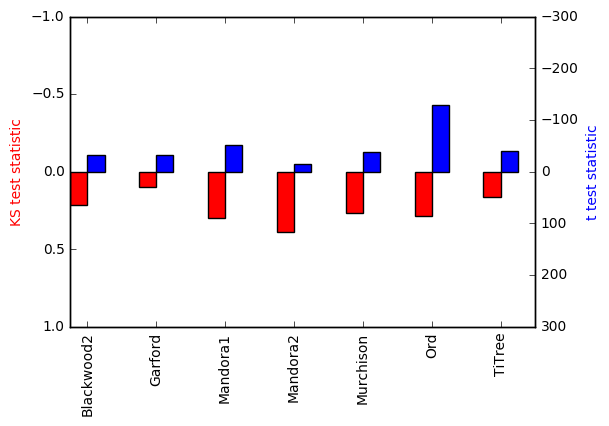

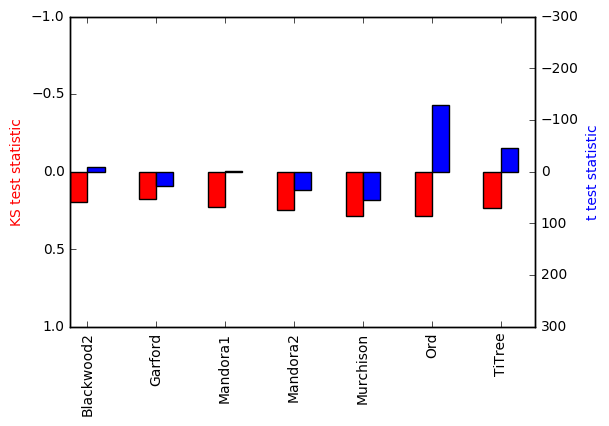

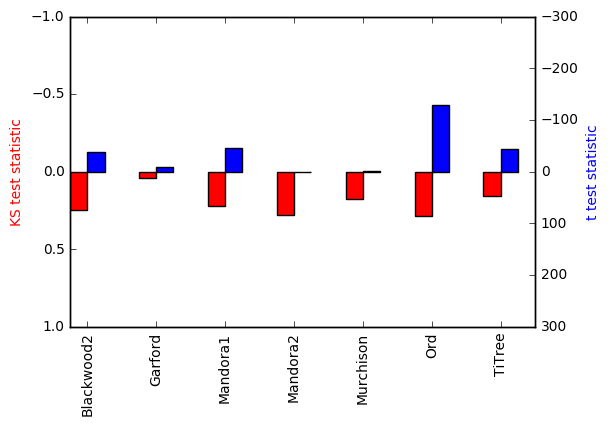

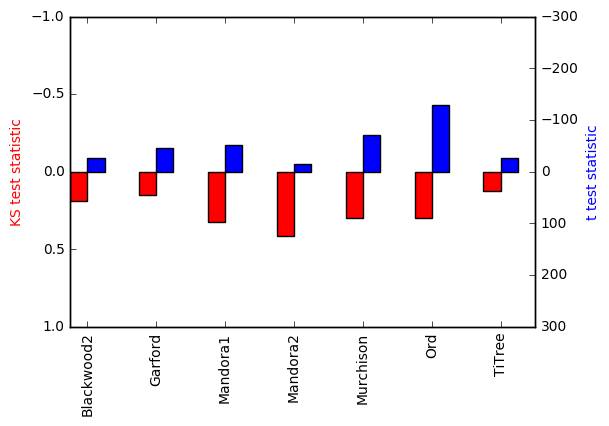

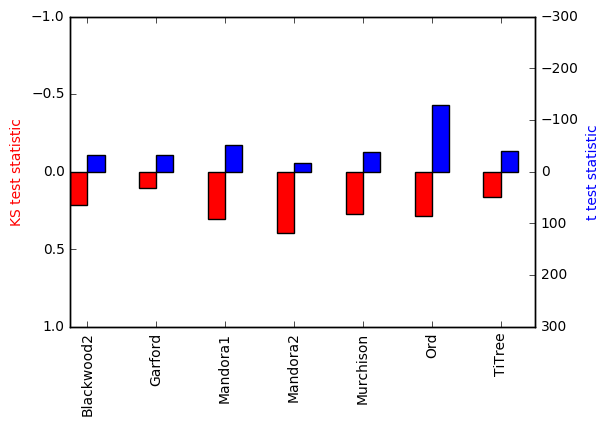

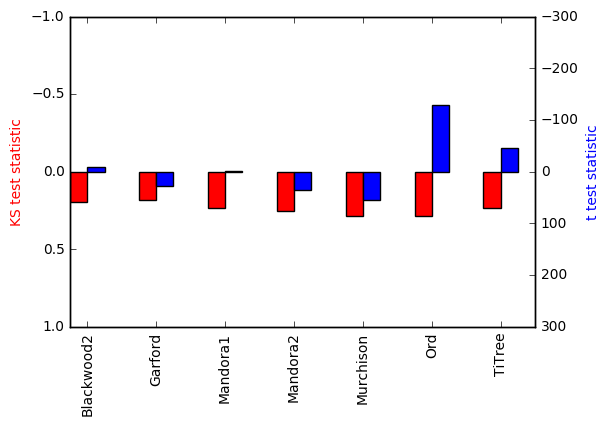

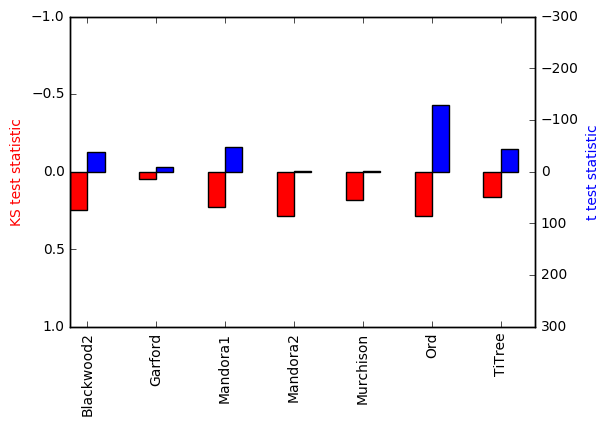

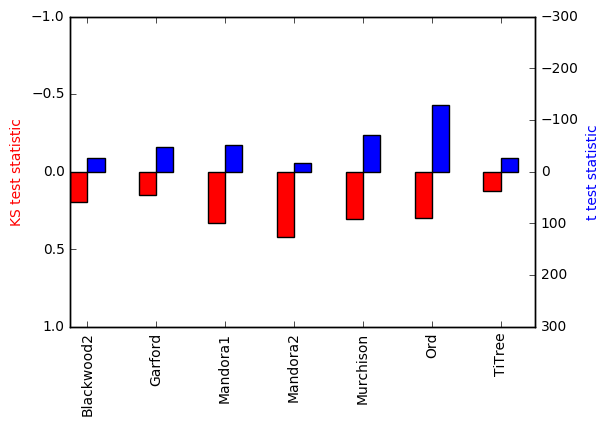

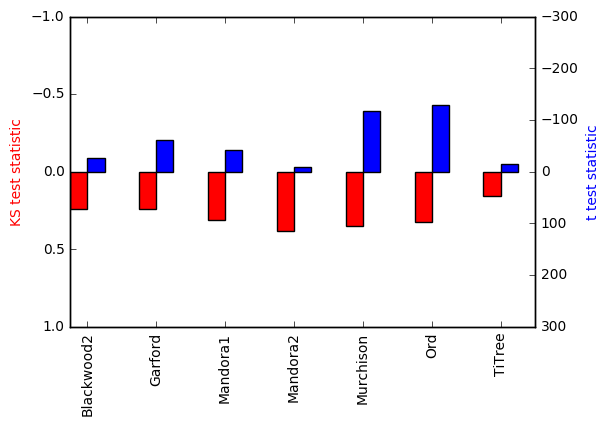

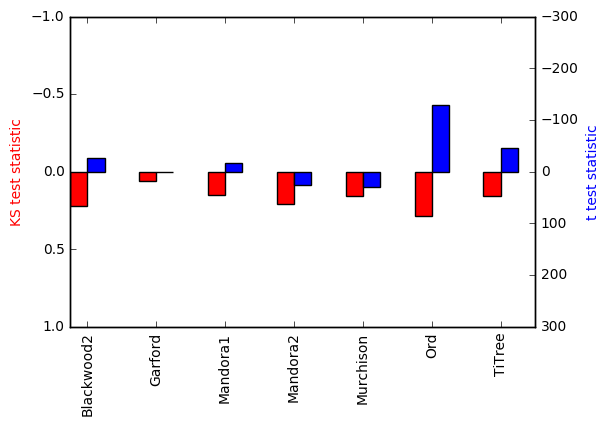

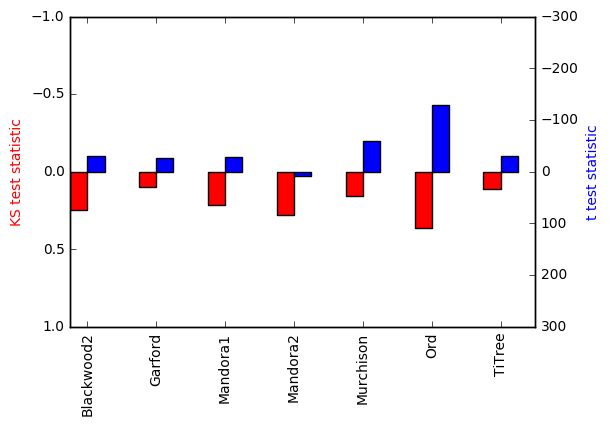

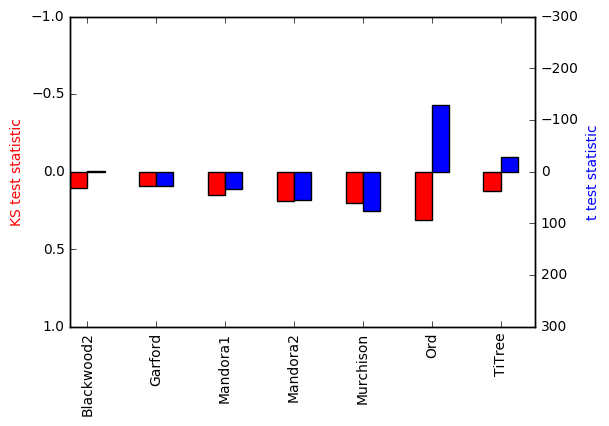

In [5]:
study_sites = pandas.read_csv('/g/data/p25/cek156/case_study_sites.csv')

# Loop through measurement csv files
for keys in dataset.measurements:
    OUTPUT = '/g/data/p25/cek156/radiometrics' + keys + '.csv'

    #Read in the CSV with the stats
    gamma_stats = pandas.read_csv(OUTPUT)

    mean_values = pandas.DataFrame(columns = ['Site', 'ttest_mean', 'KS_mean'])

    exclude_last_three = study_sites[:-3]
    for idx, site in enumerate(exclude_last_three.Name):
        ttest_mean = gamma_stats[gamma_stats.name.str.contains(site)].ttest.mean()
        ks_mean = gamma_stats[gamma_stats.name.str.contains(site)].KS_test.mean()
        mean_values.loc[idx] = [site, ttest_mean, ks_mean]

    print(mean_values)
    
    # And plot up the results for this measurement!
    
    # Setting the positions and width for the bars
    pos = list(range(len(mean_values.ttest_mean)))
    width = 0.25

    fig = plt.figure()

    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

    mean_values.KS_mean.plot(kind='bar', color='red', ax=ax, width=width, position=1)
    mean_values.ttest_mean.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

    # Set the y axis label
    ax.set_ylabel('KS test statistic', color='red')
    ax2.set_ylabel('t test statistic', color='blue')

    # Set the labels for the x ticks
    ax.set_xticklabels(mean_values['Site'])

    # Setting the x-axis and y-axis limits

    ax2.set_ylim([300, -300])
    ax.set_ylim([1, -1])

    #Let's save the plot
    fig.savefig('/g/data/p25/cek156/' + keys + '_stats.jpg', bbox_inches='tight')